In [57]:
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install sklearn
!pip3 install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path
import os


In [59]:

dirname = os.getcwd()
# from config.definitions import ROOT_DIR
filename = os.path.join(dirname, 'dataset', 'telco_dataset.csv')
df_load = pd.read_csv(filename)
#Tampilkan bentuk dari dataset
print(df_load.shape)
#Tampilkan 5 data teratas
print(df_load.head())
#Tampilkan jumlah ID yang unik
print(df_load.customerID.nunique())

(6950, 13)
   UpdatedAt   customerID  gender SeniorCitizen Partner  tenure PhoneService  \
0     202006  45759018157  Female            No     Yes       1           No   
1     202006  45315483266    Male            No     Yes      60          Yes   
2     202006  45236961615    Male            No      No       5          Yes   
3     202006  45929827382  Female            No     Yes      72          Yes   
4     202006  45305082233  Female            No     Yes      56          Yes   

  StreamingTV InternetService PaperlessBilling  MonthlyCharges  TotalCharges  \
0          No             Yes              Yes           29.85         29.85   
1          No              No              Yes           20.50       1198.80   
2         Yes             Yes               No          104.10        541.90   
3         Yes             Yes              Yes          115.50       8312.75   
4         Yes             Yes               No           81.25       4620.40   

  Churn  
0    No  
1    No

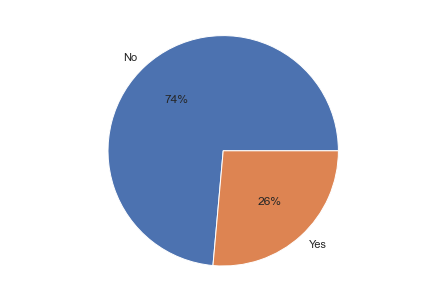

In [60]:
#memvisualisasi persentase Churn pada dataset 
fig = plt.figure() 
ax = fig.add_axes([0,0,1,1]) 
ax.axis('equal') 
labels = ['No','Yes'] 
churn = df_load.Churn.value_counts() 
ax.pie(churn, labels=labels, autopct='%.0f%%') 
plt.show()

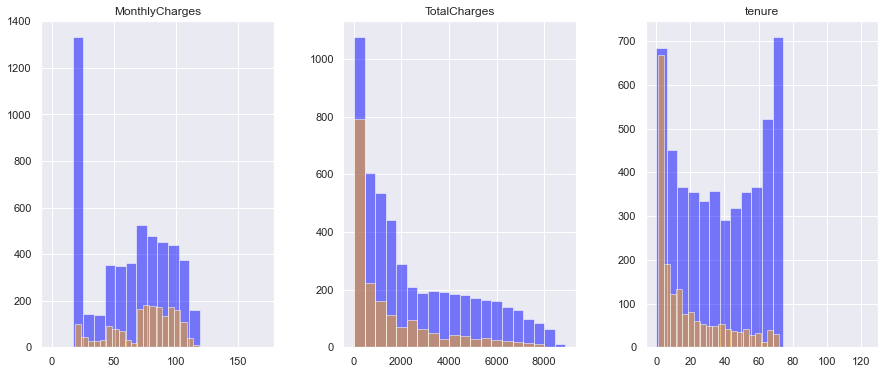

In [61]:
#membuat distribution diagram untuk 3 variabel numerik berikut 
numerical_features = ['MonthlyCharges','TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
#gunakan code berikut ini untuk memplot 2 lapisan untuk membedakan mana yang Churn (Orange) atau Tidak (Blue) 
df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

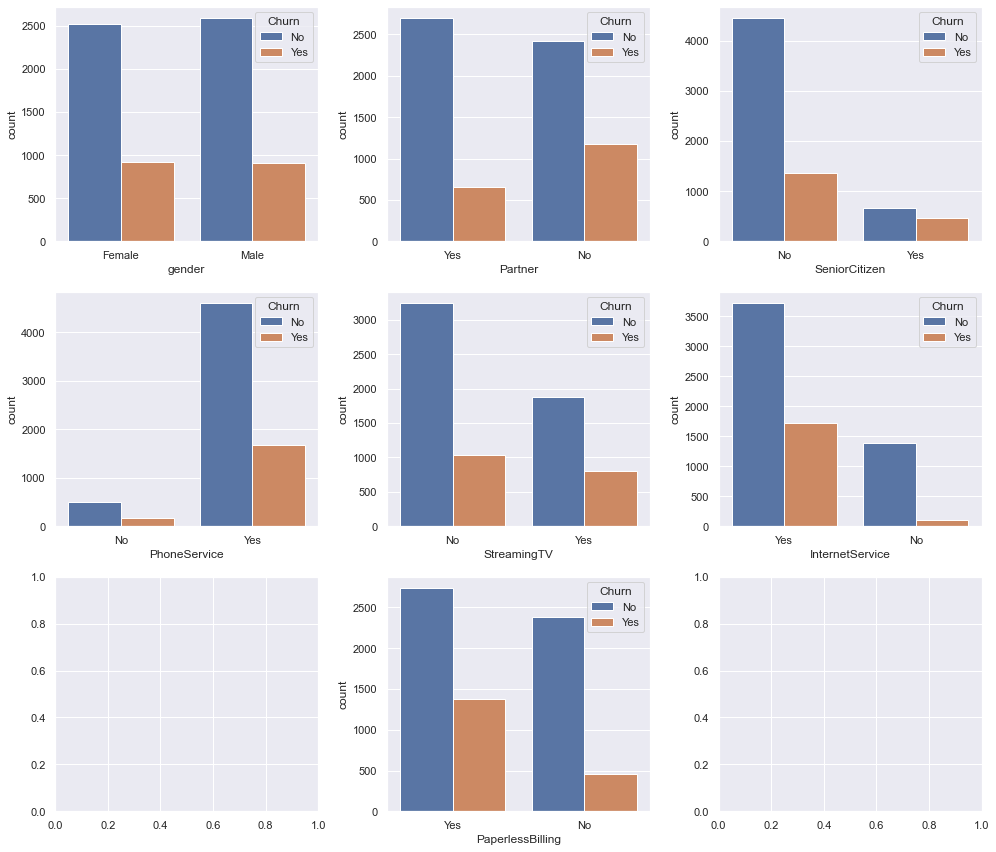

In [62]:
sns.set(style='darkgrid')
# memplot data dengan subplot ukuran 3x3
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
# menampilkan data berdasarkan variabel-variabel kategorikal yang ada
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

In [63]:
# hapus variabel customerID dan UpdatedAt dari dataset
cleaned_df = df_load.drop(['customerID', 'UpdatedAt'], axis=1)
print(cleaned_df.head())

   gender SeniorCitizen Partner  tenure PhoneService StreamingTV  \
0  Female            No     Yes       1           No          No   
1    Male            No     Yes      60          Yes          No   
2    Male            No      No       5          Yes         Yes   
3  Female            No     Yes      72          Yes         Yes   
4  Female            No     Yes      56          Yes         Yes   

  InternetService PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0             Yes              Yes           29.85         29.85    No  
1              No              Yes           20.50       1198.80    No  
2             Yes               No          104.10        541.90   Yes  
3             Yes              Yes          115.50       8312.75    No  
4             Yes               No           81.25       4620.40    No  


In [64]:
from sklearn.preprocessing import LabelEncoder
#konversi semua variabel tipe non-numerikal ke tipe numerikal  
for column in cleaned_df.columns:
    if cleaned_df[column].dtype == np.number: continue
    #terapkan encoding pada tiap variabel non-numerikal
    cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner       tenure  PhoneService  \
count  6950.000000    6950.000000  6950.000000  6950.000000   6950.000000   
mean      0.504317       0.162302     0.483309    32.415827      0.903741   
std       0.500017       0.368754     0.499757    24.561336      0.294967   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     9.000000      1.000000   
50%       1.000000       0.000000     0.000000    29.000000      1.000000   
75%       1.000000       0.000000     1.000000    55.000000      1.000000   
max       1.000000       1.000000     1.000000    73.000000      1.000000   

       StreamingTV  InternetService  PaperlessBilling  MonthlyCharges  \
count  6950.000000      6950.000000       6950.000000     6950.000000   
mean      0.384317         0.783453          0.591942       64.992201   
std       0.486468         0.411921          0.491509       30.032040   
min       0.00

C:\Users\Luky\AppData\Local\Temp\ipykernel_20912\124805503.py:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_df[column].dtype == np.number: continue


In [65]:
from sklearn.model_selection import train_test_split
# Predictor -> X dan target -> y
X = cleaned_df.drop('Churn', axis = 1)
y = cleaned_df['Churn']
# Splitting data train dan data test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print deskripsi
print('Jumlah baris dan kolom dari x_train adalah: ', x_train.shape, ', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Persentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:', x_test.shape, ', sedangkan Jumlah baris dan kolom dari y_test adalah:', y_test.shape)
print('Persentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah:  (4865, 10) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Persentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2085, 10) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2085,)
Persentase Churn di data Testing adalah:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


In [66]:
from sklearn.ensemble import RandomForestClassifier
#Latih model dengan RandomForestClassifier()
rdf_model = RandomForestClassifier().fit(x_train, y_train)
print(rdf_model)

RandomForestClassifier()


In [67]:
#Menampilkan hasil training dengan confusion matrix
from sklearn.metrics import classification_report
# Predict
y_train_pred = rdf_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Random Forest) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      0.99      0.99      1290

    accuracy                           1.00      4865
   macro avg       1.00      0.99      0.99      4865
weighted avg       1.00      1.00      1.00      4865



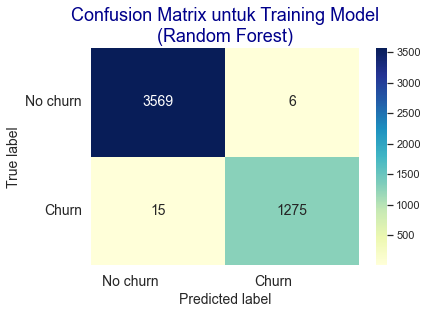

In [68]:
#Menampilkan hasil training model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [69]:
#Menampilkan hasil testing model dengan confusion matrix 
# Predict 
y_test_pred = rdf_model.predict(x_test) 
# Print classification report 
print('Classification Report Testing Model (Random Forest):') 
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1539
           1       0.60      0.47      0.53       546

    accuracy                           0.78      2085
   macro avg       0.71      0.68      0.69      2085
weighted avg       0.77      0.78      0.77      2085



In [70]:
#Menampilkan hasil testing model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

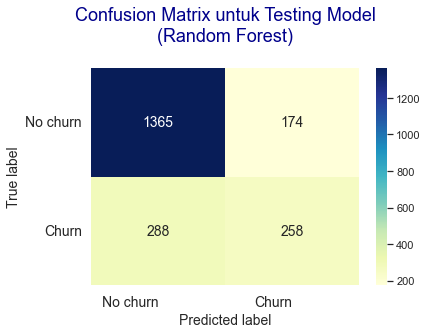

In [71]:
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Testing Model\n(Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [73]:
#Save Model log_model (Random Forest) sebagai model terbaik 
pickle.dump(rdf_model, open('best_model_churn.pkl', 'wb'))